## Implement of a Gaussian curvature tensor

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim

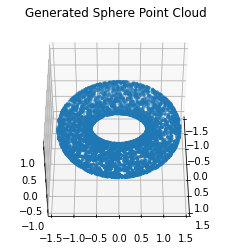

In [2]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    

    return np.column_stack((x, y, z))

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a sphere point cloud with 1000 points and radius 1
torus = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=5)

ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(45, 0)
plt.show()

In [3]:
def find_basis(point_cloud, x,  extrin_dim = 3, epsilon_PCA = 0.1, tau_radius = 0.4):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.05 * point_cloud.shape[0])

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(x, epsilon_PCA, return_distance=True, sort_results = True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(x, tau_radius, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - x
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT[:extrin_dim, :]
    
    x_idx = ep_idx[0][0]
    
    return tau_nbrs, x_idx, O
   
    
        
    

In [4]:
idx =2000
query = torus[idx].reshape(1, -1)

nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(torus)
ep_dist, ep_idx = nbrs.radius_neighbors(query, 0.4, return_distance=True, sort_results = True)


In [5]:
tau_nbrs, x_idx, O = find_basis(torus, query,  extrin_dim = 3, epsilon_PCA = 0.1, tau_radius = 0.4)

In [6]:
def compute_sectional_curvature_at_point(point_cloud, query_point, intrin_dims, extrin_dim = 3, 
                                         epsilon_PCA = 0.1, tau_radius = 0.5, max_min_num = 10, mix_dim = False):
    
    tau_nbrs, x_idx, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                                    epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
    
    gaussian_cur = 0

    if mix_dim: 
        dim = intrin_dims[x_idx]
        tensor_all = []
            
        if dim == 3:
            dim = 2
        for i in np.arange(1, len(tau_nbrs)):
            tensor = 2 * (sum(O[dim] *  (tau_nbrs[i] - tau_nbrs[0])))/np.linalg.norm(tau_nbrs[i] - tau_nbrs[0])**2
            tensor_all.append(tensor)
            
        if dim == 1:
            avg = sum(tensor_all)/len(tensor_all)
            if avg > 0:
                gaussian_cur = sum(sorted(tensor_all, reverse=True)[:3])/3
            if avg < 0: 
                gaussian_cur = - sum(sorted(tensor_all)[:3])/3
        else:
            max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num
            min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
            gaussian_cur = max_cur * min_cur
        
    else: 
        tensor_all = []
        for i in np.arange(1, len(tau_nbrs)):
            tensor = 2 * (sum(O[2] *  (tau_nbrs[i] - tau_nbrs[0])))/np.linalg.norm(tau_nbrs[i] - tau_nbrs[0])**2
            tensor_all.append(tensor)

        max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num
        min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
        gaussian_cur = max_cur * min_cur
    
    
    return gaussian_cur
 

In [7]:
def run_curvature_mix_dim(point_cloud, extrin_dim = 3, epsilon_PCA = 0.1, 
                          tau_radius = 1, max_min_num = 10, mix_dim = False):
    lpca = skdim.id.lPCA().fit_pw(point_cloud, n_neighbors = 10, n_jobs = 1)
    intrin_dims = lpca.dimension_pw_
    
    num_eval = int(len(point_cloud))
    curvature = []
    for i in tqdm(range(num_eval)):
        b = compute_sectional_curvature_at_point(point_cloud, point_cloud[i].reshape(1, -1), intrin_dims,
                                                 epsilon_PCA =epsilon_PCA, tau_radius = tau_radius, 
                                                 max_min_num = max_min_num, mix_dim = mix_dim)
        curvature.append(b)
        v = np.array(curvature).T
    return v
        
                   
    
    


In [31]:
v = run_curvature_mix_dim(torus, extrin_dim = 3, epsilon_PCA = 0.2, 
                          tau_radius = 1, max_min_num = 100, mix_dim = False)

100%|██████████| 5000/5000 [01:04<00:00, 77.40it/s]


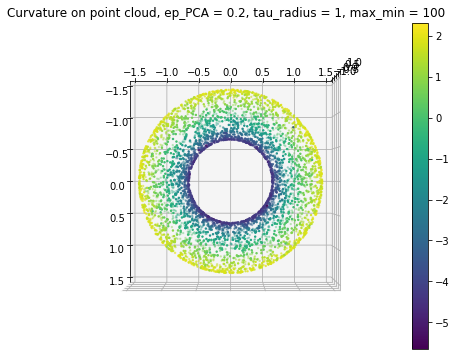

In [32]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=2, c = v)
ax.set_title("Curvature on point cloud, ep_PCA = 0.2, tau_radius = 1, max_min = 100")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

# For mixed dimension

In [76]:
u_lim = 5
a, b, c = 0.05, 0.05, 0.05
J_length = 6
J_radius = 1.5

In [77]:
1/(np.sqrt(b**2 * np.cosh(u_lim)**2 + (b**4 * np.sinh(u_lim)**2)/c**2))**2

0.03631994373512688

In [78]:
def generate_ballon(a, b, c, u_lim = 5, J_length = 6, J_radius = 3, num_points=5000, shuffle = True):
    num_hyper = int(num_points * 0.4)
    num_sphere = int(num_points * 0.4)
    num_J = int(num_points * 0.2)
    
    #generate hyperboloid upper
    u = np.random.uniform(0, u_lim, num_hyper)
    v = np.random.uniform(0, 2 * np.pi, num_hyper)

    x_h = a*np.cosh(u)*np.cos(v)
    y_h = b*np.cosh(u)*np.sin(v)
    z_h = c*np.sinh(u)

    hyper = np.column_stack((x_h, y_h, z_h))
    
    #generate sphere upper
    theta = np.random.uniform(0, 2 * np.pi, num_sphere)
    phi = np.random.uniform(0, np.pi/2 + np.arctan((b*np.sinh(u_lim))/(c*np.cosh(u_lim))), num_sphere)
    
    radius = np.sqrt(b**2 * np.cosh(u_lim)**2 + (b**4 * np.sinh(u_lim)**2)/c**2)

    x_s = radius * np.sin(phi) * np.cos(theta)
    y_s = radius * np.sin(phi) * np.sin(theta)
    z_s = radius * np.cos(phi) + b**2 * np.sinh(u_lim)/c + c*np.sinh(u_lim)
    z_0 = b**2 * np.sinh(u_lim)/c + c*np.sinh(u_lim)
    
    sphere = np.column_stack((x_s, y_s, z_s))
    center = np.column_stack((0, 0, z_0))
    
    #generate J shape
    total = J_length + np.pi * J_radius
    ratio_1 = J_length/total
    num_1 = int(num_J * ratio_1)
    t = np.linspace(0, - J_length, num_1)
    x1, y1 = np.zeros(num_1), np.zeros(num_1)
    z1 = t
    X1 = np.zeros((num_1,3))
    X1[:, 0] = x1
    X1[:, 1] = y1
    X1[:, 2] = z1
    
    num_2 = num_J - num_1
    theta = np.linspace(np.pi, 2*np.pi, num_2)
    x2 = np.zeros(num_2)
    y2 = -J_radius + J_radius * np.cos(theta)
    z2 = -J_length + J_radius * np.sin(theta)
    X2 = np.zeros((num_2,3))
    X2[:, 0] = x2
    X2[:, 1] = y2
    X2[:, 2] = z2
    
    J = np.concatenate((X1, X2), axis= 0)
    
    Y = np.concatenate((hyper, sphere, J), axis= 0)
    if shuffle:
        np.random.shuffle(Y)

    return Y, center


np.random.seed(40)
# Generate a sphere point cloud with 1000 points and radius 1

ballon, center = generate_ballon(a, b, c, u_lim = u_lim, J_length = J_length, J_radius = J_radius, 
                                 num_points=5000, shuffle = False)

#ballon = ballon[4000:]

#np.random.shuffle(ballon)


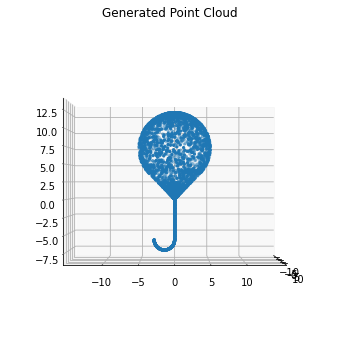

In [79]:
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ballon[:, 0], ballon[:, 1], ballon[:, 2], s=5)
ax.set_title("Generated Point Cloud")
ax.view_init(0, 0)
plt.axis('equal')
plt.show()

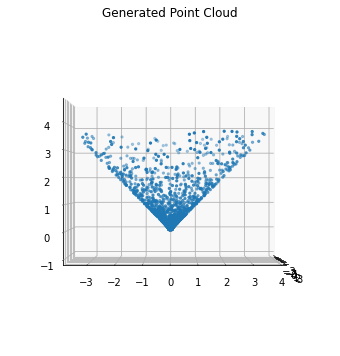

In [95]:
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ballon[:2000, 0], ballon[:2000, 1], ballon[:2000, 2], s=5)
ax.set_title("Generated Point Cloud")
ax.view_init(0, 0)
plt.axis('equal')
plt.show()

In [80]:
v = run_curvature_mix_dim(ballon, extrin_dim = 3, epsilon_PCA = 1, 
                          tau_radius = 1, max_min_num = 100, mix_dim = True)

100%|██████████| 5000/5000 [00:36<00:00, 138.42it/s]


In [84]:
dd = np.clip(v, a_max=2, a_min=-1)

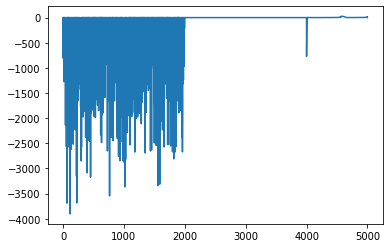

In [82]:
plt.plot(v)

In [280]:
lpca = skdim.id.lPCA().fit_pw(ballon, n_neighbors = 50, n_jobs = 1)
intrin_dims = lpca.dimension_pw_
one_d_idx = np.where(intrin_dims == 1)

In [ ]:
def smooth_singularity_point(point_cloud, curvature):
    lpca = skdim.id.lPCA().fit_pw(point_cloud, n_neighbors = 50, n_jobs = 1)
    intrin_dims = lpca.dimension_pw_
    one_dim_idx = np.where(intrin_dims == 1)
    
    

In [67]:
min(v)

-3904.8199768023333

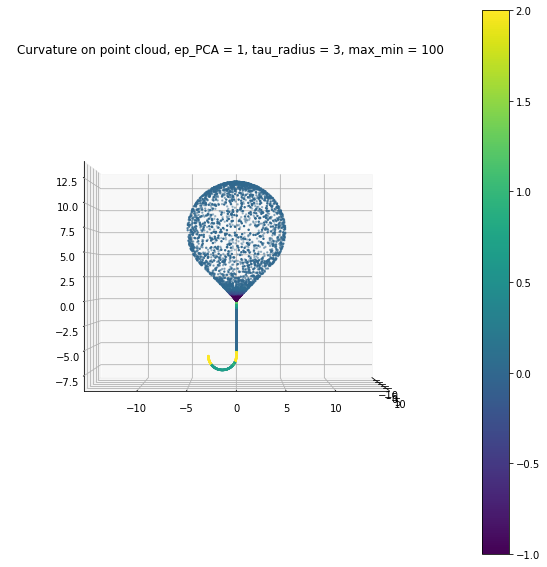

In [85]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ballon[:, 0], ballon[:, 1], ballon[:, 2], s=2, c = dd)
ax.set_title("Curvature on point cloud, ep_PCA = 1, tau_radius = 3, max_min = 100")
ax.view_init(0, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [218]:
dd = np.clip(v, a_max=1, a_min=None)

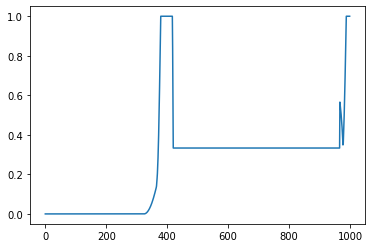

In [219]:
plt.plot(dd)

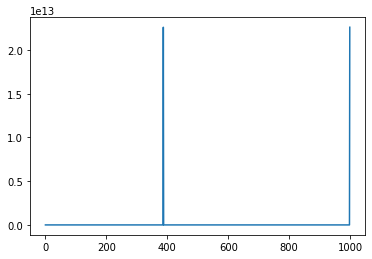

In [256]:
plt.plot(v)

In [223]:
outliers = np.where(v > np.mean(v) + 3 * np.std(v))[0]
outliers

array([387, 999])

In [86]:
a = v

outliers = np.where(a > np.mean(a) + 3 * np.std(a))[0]
for i in range(10):
    outliers = np.where(a > np.mean(a) + 1 * np.std(a))[0]
    for outlier_index in outliers:
    # Replace with the mean of neighbors
        a[outlier_index] = 1/2 * np.mean(a[outlier_index-6 : outlier_index-3]) 
        + 1/2 * np.mean(a[outlier_index + 4: outlier_index + 7])

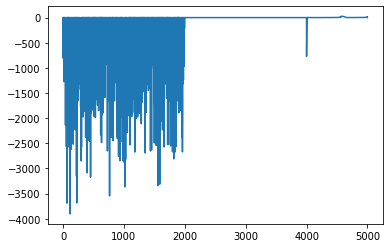

In [87]:
plt.plot(a)

In [88]:
lpca = skdim.id.lPCA().fit_pw(ballon, n_neighbors = 50, n_jobs = 1)
intrin_dims = lpca.dimension_pw_

In [92]:
idx = 4700

x = ballon[idx].reshape(1, -1)

tau_nbrs, x_idx, O = find_basis(ballon, x,  extrin_dim = 3, epsilon_PCA = 0.5, tau_radius = 1)

In [93]:
O

array([[ 0.        ,  0.84248238, -0.53872389],
       [ 0.        ,  0.53872389,  0.84248238],
       [ 1.        ,  0.        ,  0.        ]])

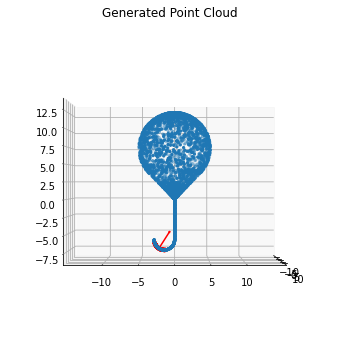

In [94]:
def plot_vector(ax, a, v, color='red', label=None):
    ax.quiver(a[0], a[1], a[2], v[0], v[1], v[2], color=color, label=label, arrow_length_ratio=0.1)

# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ballon[:, 0], ballon[:, 1], ballon[:, 2], s=5)
ax.scatter(ballon[idx, 0], ballon[idx, 1], ballon[idx, 2], s=10, c = 'r')

ax.scatter(tau_nbrs[:, 0], tau_nbrs[:, 1], tau_nbrs[:, 2], s=10, c = 'r')
plot_vector(ax, ballon[idx], 3 * O[1])
ax.set_title("Generated Point Cloud")
ax.view_init(0, 0)
plt.axis('equal')
plt.show()


In [195]:
k = [1, 2, 3, 4, 5]

In [197]:
k[2-2: 2]

[1, 2]

In [200]:
k[2+1: 2+3]

[4, 5]